In [1]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

image_dir = "./images"
label_dir = "./labels"

images = glob(os.path.join(image_dir, '*.png'))
labels = glob(os.path.join(label_dir, '*.png'))

In [2]:
tags = {0:None, 
        1:"Buildings", 
        2:"Fences",
        3:"Other",
        4:"Pedestrians",
        5:"Poles",
        6:"RoadLines",
        7:"Roads",
        8:"Sidewalks",
        9:"Vegetation",
        10:"Vehicles",
        11:"Walls",
        12:"TrafficSigns"}

total_images = len(images)
total_labels = len(labels)
print("Total images:", total_images)
print("Total labels:", total_labels)

Total images: 1000
Total labels: 1000


In [3]:
# creating data object
d = {'image':images, 'label':labels}
columns = ['image', 'label']
data = pd.DataFrame(d, columns=columns)

Since the training dataset contains hood pixels, we have to get rid of them. 
But the test dataset with same resilution will not contain hood pixels.
My solution is:
- crop the images in test dataset by cutting 100 bottom pixels 
- resize the obtained image so the dimentions can be scaled to the initial size (i.e. since the height loses 100 pixels it becomes 5/6 of the initial number. So the width must become 800*5/6 = 666)
- during training perform scaling and shifting augmentation.  

In [57]:
# getting rid of the bottom pixels and resize images and labels.

def get_image_and_labels(sample, shape=(666,500)):
    image = cv2.imread(sample['image'])
    label = cv2.imread(sample['label'])[:,:,2]
    image = image[:500,:,:]
    label = label[:500,:]
    
    # get label for road pixels (road and lane lines must be the same label)
    label[label == 6] = 7
    label_road = np.zeros_like(label)
    label_road[label == 7] = 1
    
    # get label for car pixels
    label_car = np.zeros_like(label)
    label_car[label == 10] = 1
    
    # resizing
    image = cv2.resize(image, shape, interpolation = cv2.INTER_CUBIC)
    label_car = cv2.resize(label_car, shape, interpolation = cv2.INTER_CUBIC)
    label_road = cv2.resize(label_road, shape, interpolation = cv2.INTER_CUBIC)
    return image, label_car, label_road

def get_real_labels(sample):
    label = cv2.imread(sample['label'])[:,:,2]
    label[label == 6] = 7
    label_road = np.zeros_like(label)
    label_road[label == 7] = 1
    label_car = np.zeros_like(label)
    label_car[label == 10] = 1
    return label_car, label_road

Let's see if we aren't losing anything after applying the transformations.

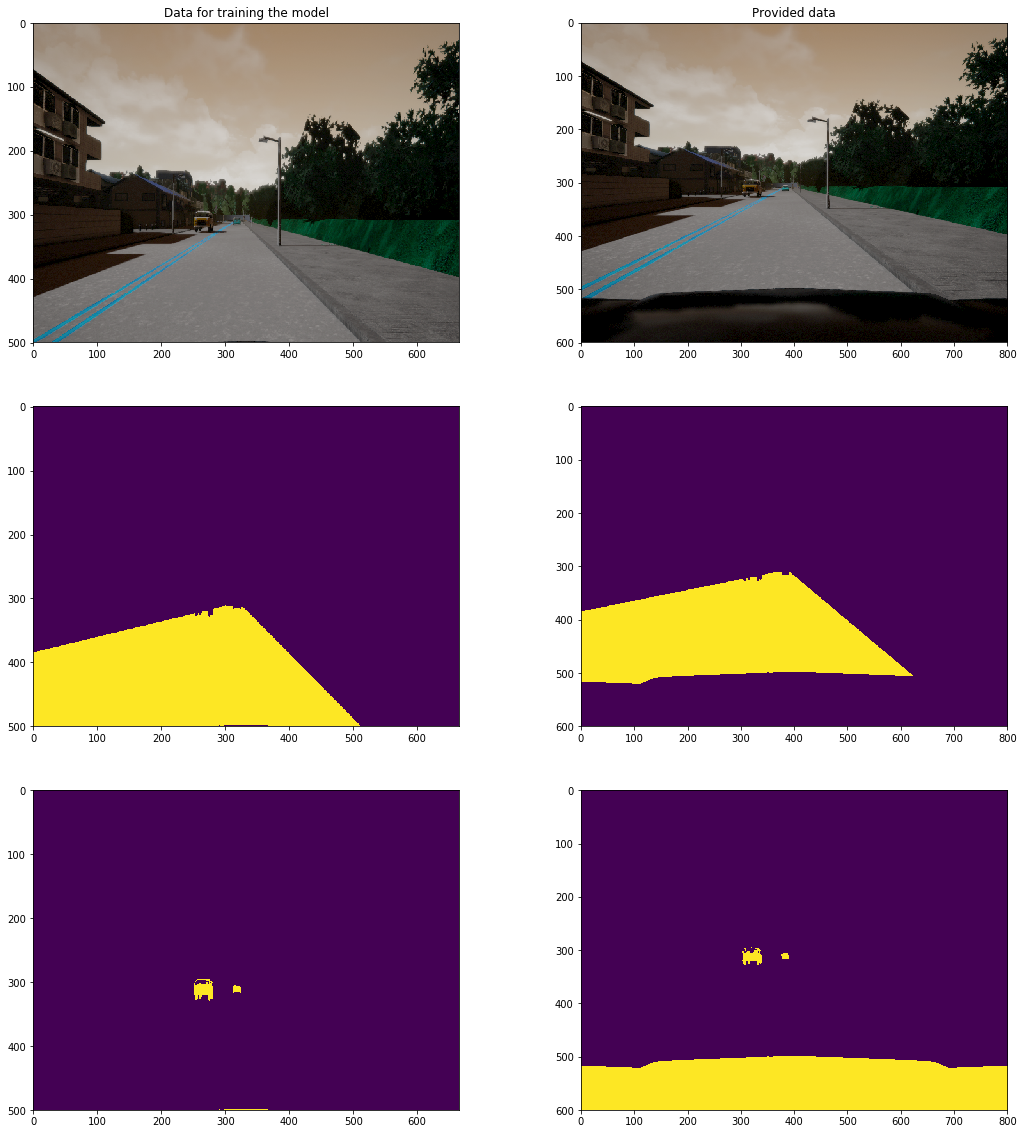

In [60]:
sample = data.iloc[2]
dataset_image = cv2.imread(sample['image'])
train_image, label_car, label_road = get_image_and_labels(sample)

lb_car, lb_road = get_real_labels(sample)

fig, axarr = plt.subplots(3,2,figsize = (18,20))

axarr[0,0].set_title('Data for training the model')
axarr[0,0].imshow(train_image)
axarr[0,1].set_title('Provided data')
axarr[0,1].imshow(dataset_image)

axarr[1,0].imshow(label_road)
axarr[1,1].imshow(lb_road)

axarr[2,0].imshow(label_car)
axarr[2,1].imshow(lb_car)

It seems like the sky now takes too much space. But it's ok if we'll use shifting augmentation. And the is no need to cut the sky because it can appear in the test dataset.

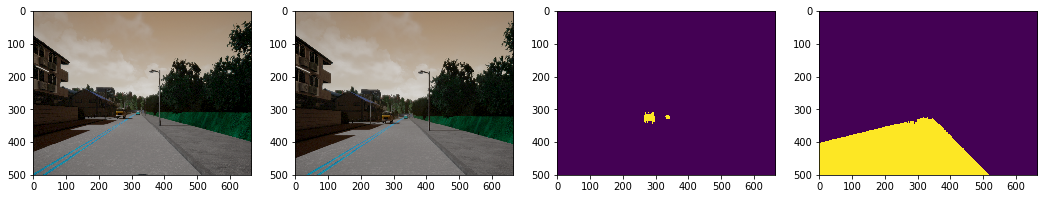

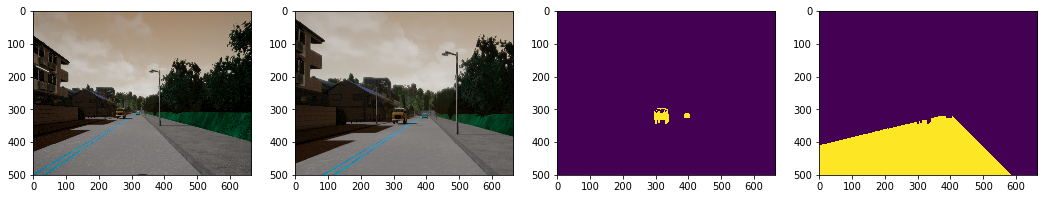

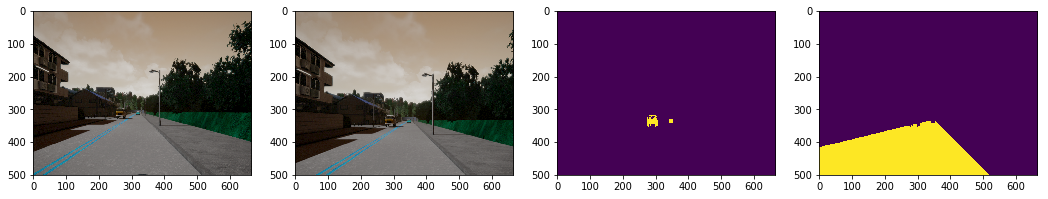

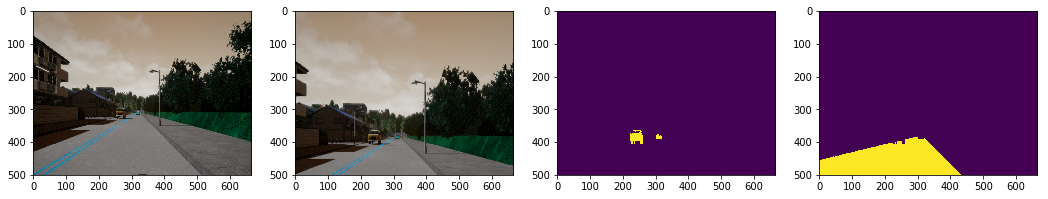

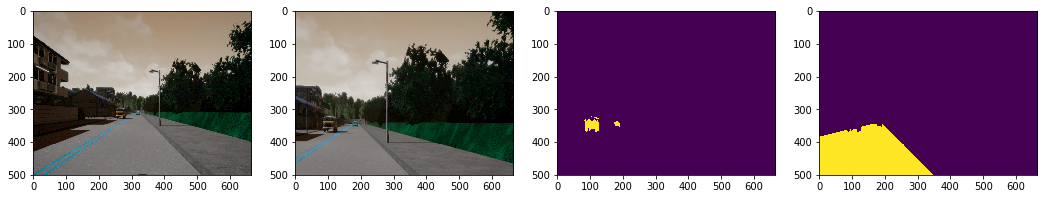

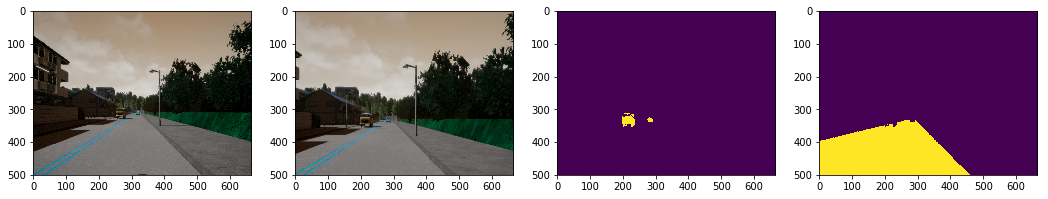

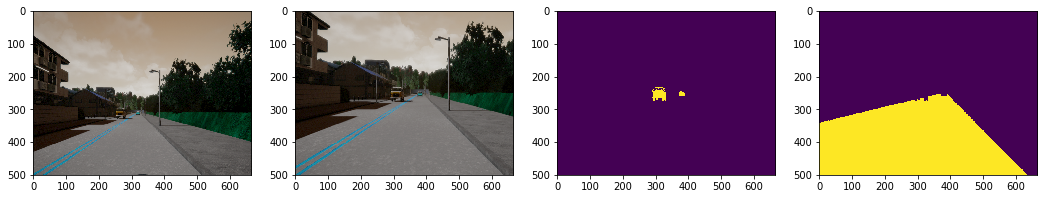

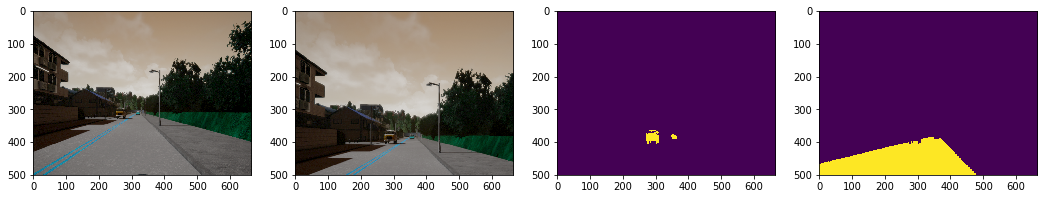

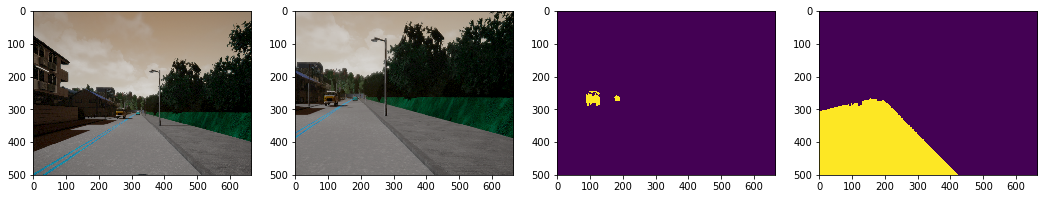

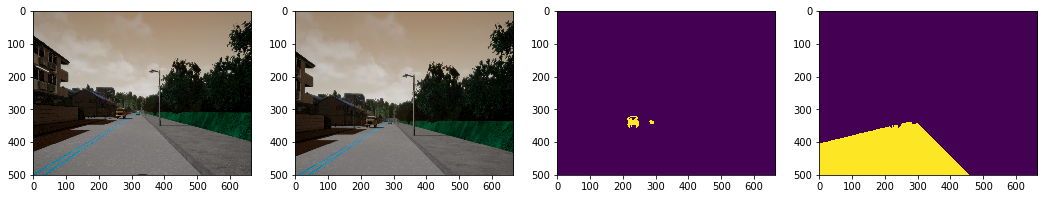

In [63]:
# functions for data augmentations 

# randomly zoom and shift the image and labels a little bit.

def get_zoomed_images_labels(img, car_label, road_label, scale=0.5):
    
    basic_width = img.shape[1]
    basic_height = img.shape[0]

    scale = scale * np.random.random()
    res_scale = 1 + scale
    zoomed_img = cv2.resize(img,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_CUBIC)
    zoomed_car = cv2.resize(car_label,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_CUBIC)
    zoomed_road = cv2.resize(road_label,None,fx=res_scale, fy=res_scale, interpolation = cv2.INTER_CUBIC)
    
    # We've got a resized image and labels. Now for the random shifting we need to slice 
    # the area of initial size starting from random position.
    # Since we shall use only 20-30% zoom, we can start from any random position
    # i.e y_start can be all the way from 0 to (zoomed_height - basic_height)
    # and x_start can be all the way from 0 to (zoomed_width - basic_width)

    max_y_start = int(basic_height * scale) 
    max_x_start = int(basic_width * scale)
    
    # random start for x:
    x_rand = np.random.random()
    x_start = int(max_x_start * x_rand)
    
    # random start for y:
    y_rand = np.random.random()
    y_start = int(max_y_start * y_rand)
    
    # now slice the zoomed images:
    zoomed_img = zoomed_img[y_start:y_start+basic_height, x_start:x_start+basic_width]
    zoomed_car = zoomed_car[y_start:y_start+basic_height, x_start:x_start+basic_width]
    zoomed_road = zoomed_road[y_start:y_start+basic_height, x_start:x_start+basic_width]
    
    return zoomed_img, zoomed_car, zoomed_road
    
    return res, scale

for i in range(10):
    fig,axarr = plt.subplots(1,4, figsize=(18,6))
    zoomed_image, car_label, road_label = get_zoomed_images_labels(train_image, label_car, label_road)
    axarr[0].imshow(train_image)
    axarr[1].imshow(zoomed_image)
    axarr[2].imshow(car_label)
    axarr[3].imshow(road_label)

It works!

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout, BatchNormalization, Conv2DTranspose

# split training and validation data

# I use only 1% of data for testing, actually I only want to visualize the results on few unseen images. 
# Since the test dataset will be different anyway, and the given dataset is not large enough,
# I just want to train the model on more samples and then just look at some new images, so 1% is enough.
# The validation size is still matters so I kept it close to 20%

train_samples, validation_data = train_test_split(data, test_size=0.2) # 80% train, 20% the rest
validation_samples, test_samples = train_test_split(validation_data, test_size=0.1) # 19% validation, 1% test
train_samples = data

im_height = 500
im_width = 666

# define the generator
def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            labels = []
            for ind, sample in batch_samples.iterrows():
                # center image
                image, lb_car, lb_road = get_image_and_labels(sample)
                final_label = np.zeros((im_height,im_width,2))
                final_label[:,:,1] = lb_road
                final_label[:,:,0] = lb_car
                final_label = final_label.reshape(im_height*im_width*2,)
                
                zoomed_image, zoomed_car, zoomed_road = get_zoomed_images_labels(image, lb_car, lb_road)
                zoomed_label = np.zeros((im_height,im_width,2))
                zoomed_label[:,:,1] = zoomed_road
                zoomed_label[:,:,0] = zoomed_car
                zoomed_label = zoomed_label.reshape(im_height*im_width*2,)
                
                images.append(image)
                labels.append(final_label)
                images.append(zoomed_image)
                labels.append(zoomed_label)
                
            X_train = np.array(images)
            y_train = np.array(labels)
            yield shuffle(X_train, y_train)

# define batch size and create the generators
batch_size = 8
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)

In [65]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D,Cropping2D
from keras.layers.normalization import BatchNormalization
import json

img_w = im_width
img_h = im_height
n_labels = 2

kernel = 3

encoding_layers = [
    Lambda(lambda x: x / 255.0 - 0.5, input_shape = (img_h, img_w, 3)),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),#, input_shape=( img_h, img_w,3)),
    BatchNormalization(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    ZeroPadding2D(((0,0),(0,1))),
    MaxPooling2D(),

    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    ZeroPadding2D(((1,0),(1,1))),
    MaxPooling2D(),

    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    ZeroPadding2D(((1,0),(0,0))),
    MaxPooling2D(),
    
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

]

model = models.Sequential()
model.encoding_layers = encoding_layers
#model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (400, 800, 3)))
#model.add(Conv2D(64, (kernel,kernel), padding='same', activation = "relu"))
for l in model.encoding_layers:
    model.add(l)

decoding_layers = [

    UpSampling2D(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    
    UpSampling2D(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Cropping2D(((1,0),(0,0))),

    UpSampling2D(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Cropping2D(((1,0),(0,1))),

    UpSampling2D(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Cropping2D(((0,0),(0,1))),

    UpSampling2D(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(n_labels, 1, padding='valid'),
    BatchNormalization(),
    Flatten(),
    Activation('sigmoid')
    
]
model.decoding_layers = decoding_layers
for l in model.decoding_layers:
#for l in decoding_layers:
    model.add(l)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_14 (Lambda)           (None, 500, 666, 3)       0         
_________________________________________________________________
conv2d_326 (Conv2D)          (None, 500, 666, 12)      336       
_________________________________________________________________
batch_normalization_326 (Bat (None, 500, 666, 12)      48        
_________________________________________________________________
conv2d_327 (Conv2D)          (None, 500, 666, 12)      1308      
_________________________________________________________________
batch_normalization_327 (Bat (None, 500, 666, 12)      48        
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 250, 333, 12)      0         
_________________________________________________________________
conv2d_328 (Conv2D)          (None, 250, 333, 24)      2616      
__________

In [66]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
stats = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, epochs=50)


Epoch 1/50
 11/125 [=>............................] - ETA: 3:06 - loss: 0.6634

ResourceExhaustedError: OOM when allocating tensor with shape[16,12,500,666] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_2/Adam/gradients/batch_normalization_350/FusedBatchNorm_grad/FusedBatchNormGrad = FusedBatchNormGrad[T=DT_FLOAT, _class=["loc:@batch_normalization_350/FusedBatchNorm"], data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_2/Adam/gradients/batch_normalization_350/cond/Switch_1_grad/cond_grad, conv2d_350/Relu, batch_normalization_350/gamma/read, batch_normalization_350/FusedBatchNorm:3, batch_normalization_350/FusedBatchNorm:4)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_2/Adam/gradients/batch_normalization_350/FusedBatchNorm_grad/FusedBatchNormGrad', defined at:
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-8b7a0f162ad6>", line 2, in <module>
    stats = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, epochs=50)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\models.py", line 1315, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 2080, in fit_generator
    self._make_train_function()
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 992, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\optimizers.py", line 445, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 2519, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 609, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 375, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 609, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 798, in _FusedBatchNormGrad
    return _BaseFusedBatchNormGrad(op, False, *grad)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 775, in _BaseFusedBatchNormGrad
    is_training=is_training)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 2695, in fused_batch_norm_grad
    name=name)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'batch_normalization_350/FusedBatchNorm', defined at:
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-65-9979150d15f0>", line 110, in <module>
    model.add(l)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\models.py", line 522, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\layers\normalization.py", line 181, in call
    epsilon=self.epsilon)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 1831, in normalize_batch_in_training
    epsilon=epsilon)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 1806, in _fused_normalize_batch_in_training
    data_format=tf_data_format)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\nn_impl.py", line 881, in fused_batch_norm
    name=name)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 2598, in _fused_batch_norm
    is_training=is_training, name=name)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[16,12,500,666] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_2/Adam/gradients/batch_normalization_350/FusedBatchNorm_grad/FusedBatchNormGrad = FusedBatchNormGrad[T=DT_FLOAT, _class=["loc:@batch_normalization_350/FusedBatchNorm"], data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_2/Adam/gradients/batch_normalization_350/cond/Switch_1_grad/cond_grad, conv2d_350/Relu, batch_normalization_350/gamma/read, batch_normalization_350/FusedBatchNorm:3, batch_normalization_350/FusedBatchNorm:4)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [26]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model_basic.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_basic.h5")
print("Saved model to disc")

Saved model to disc


In [408]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model_augmentation.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_augmentation.h5")
print("Saved model to disc")
 

Saved model to disk


In [27]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_basic.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_basic.h5")
print("Loaded model from disc")

Loaded model from disc


Visualize some predictions:

In [44]:
def get_predictions(model, img):
    img = img[:500,:,:]
    img = cv2.resize(img, (666,500))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = pred[0]
    pred = pred.reshape(500,666,2)
    car_pred = pred[:,:,0]
    road_pred = pred[:,:,1]
    
    car_pred_ = np.zeros(car_pred.shape)
    car_pred_[car_pred>0.3] = 1
    
    road_pred_ = np.zeros(road_pred.shape)
    road_pred_[road_pred>0.3] = 1
    
    return car_pred_, road_pred_

In [48]:
from sklearn.metrics import accuracy_score

def plot_results(img, lbl, car_pred, road_pred):
    fig, axarr = plt.subplots(2,3,figsize=(20,8))
    for ax in axarr:
        for subax in ax:
            subax.axis('off')
# first lane contains image and labels for car and road pixels
    axarr[0,0].set_title('Original image')
    axarr[0,0].imshow(img)
    
    lbl_car = np.zeros(lbl.shape)
    lbl_car[lbl == 10] = 1
    axarr[0,1].set_title('Car label')
    axarr[0,1].imshow(lbl_car)
    
    lbl_road = np.zeros(lbl.shape)
    lbl_road[lbl == 7] = 1
    lbl_road[lbl == 6] = 1
    axarr[0,2].set_title('Road label')
    axarr[0,2].imshow(lbl_road)

# second lane contains image and predictions for car and road pixels + accuracies
    axarr[1,0].imshow(img)
    
    car_acc = accuracy_score(car_pred, lbl_car)
    axarr[1,1].set_title('Car pred, accuracy={0}'.format(car_acc))
    axarr[1,1].imshow(car_pred)
    
    road_acc = accuracy_score(road_pred, lbl_road)
    axarr[1,2].set_title('Road pred, accuracy={0}'.format(road_acc))
    axarr[1,2].imshow(road_pred)

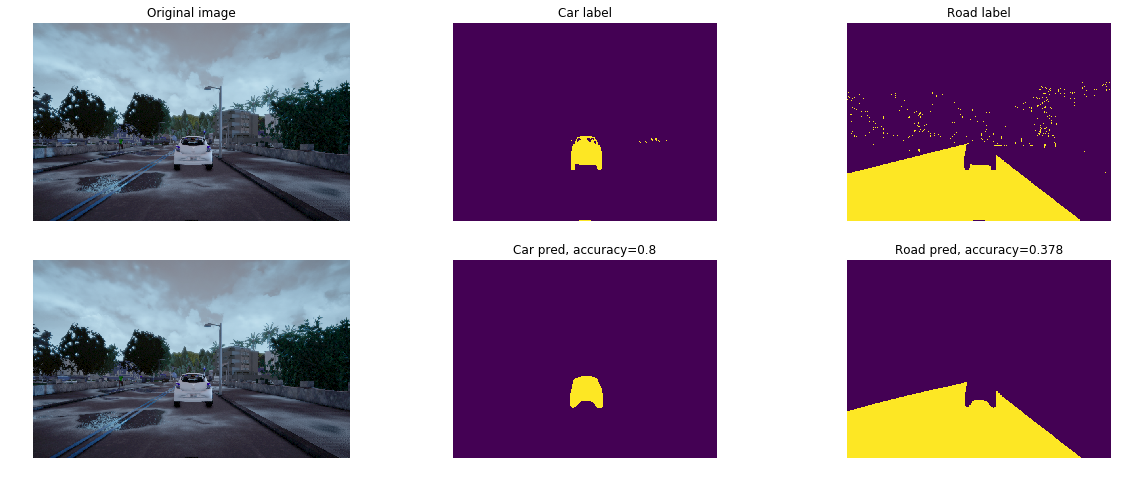

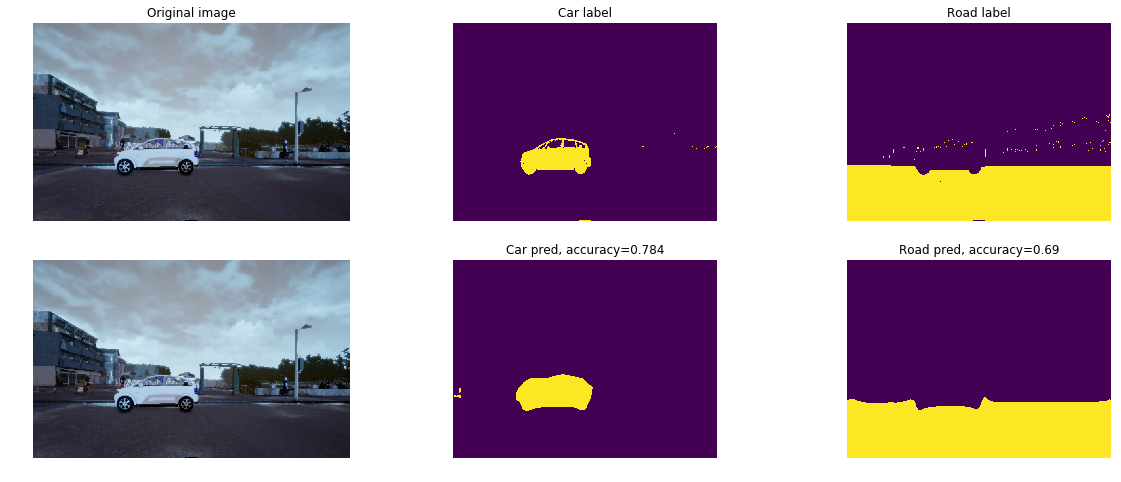

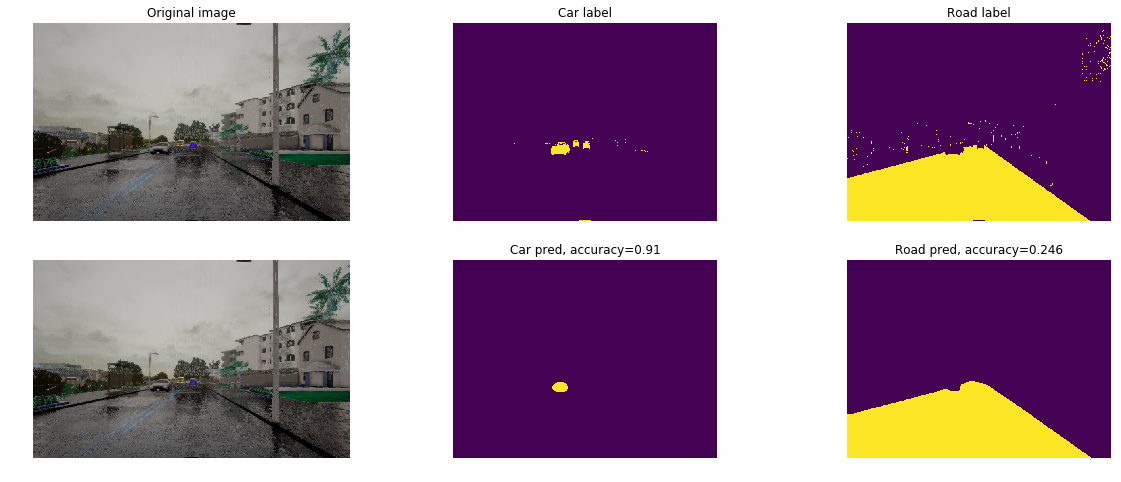

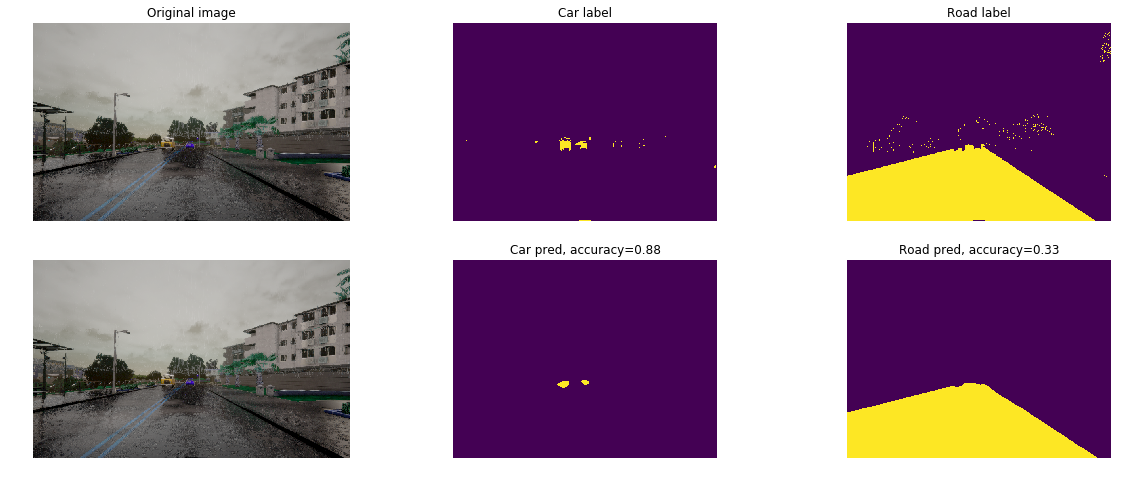

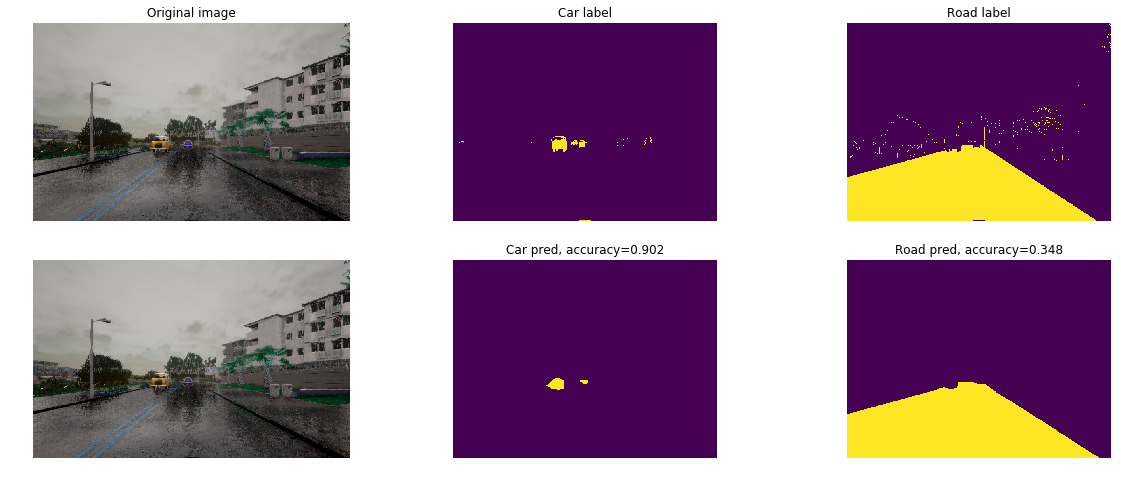

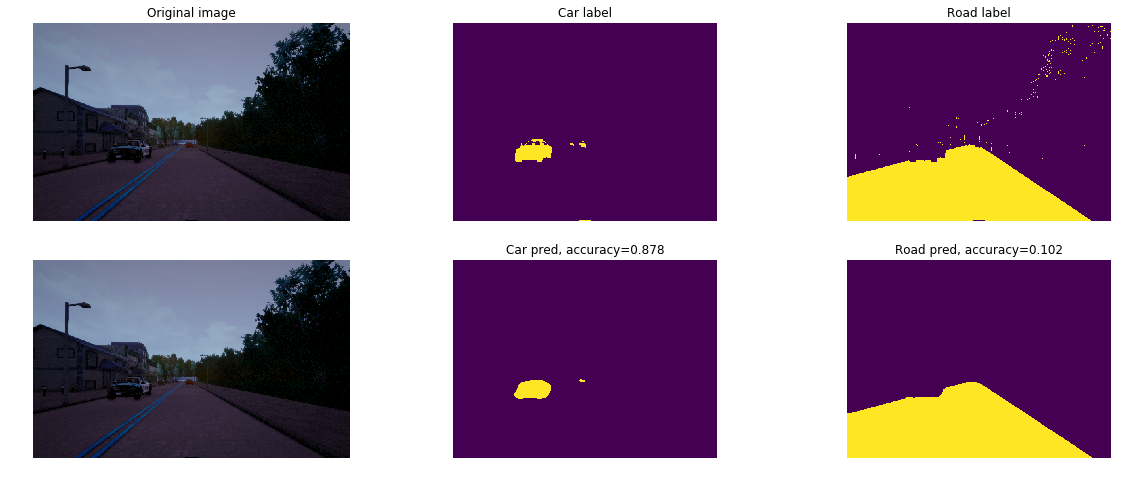

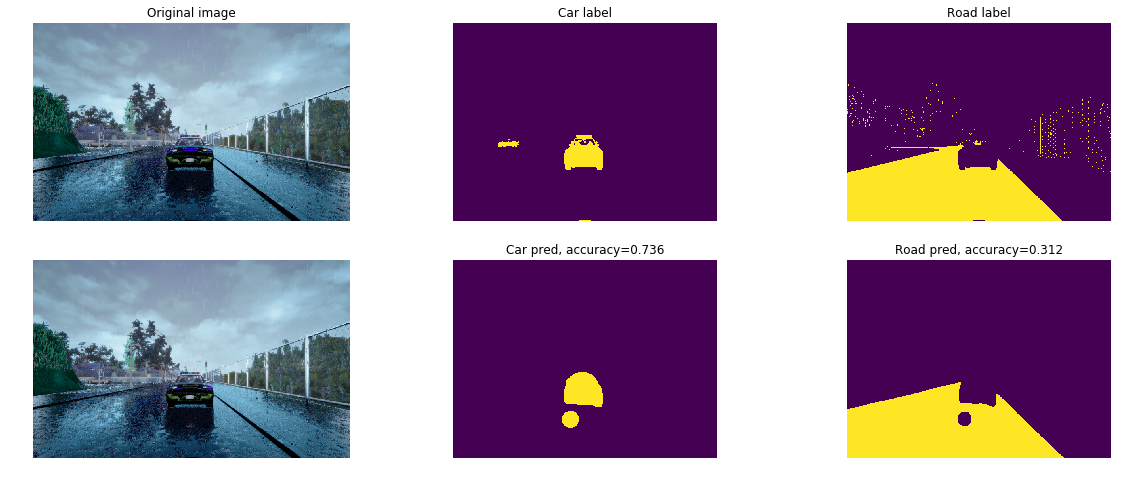

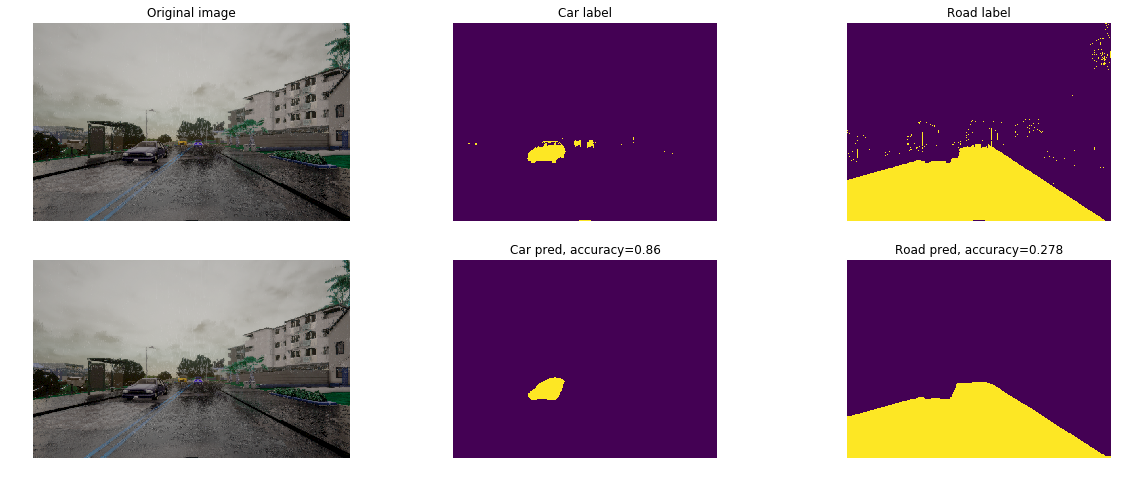

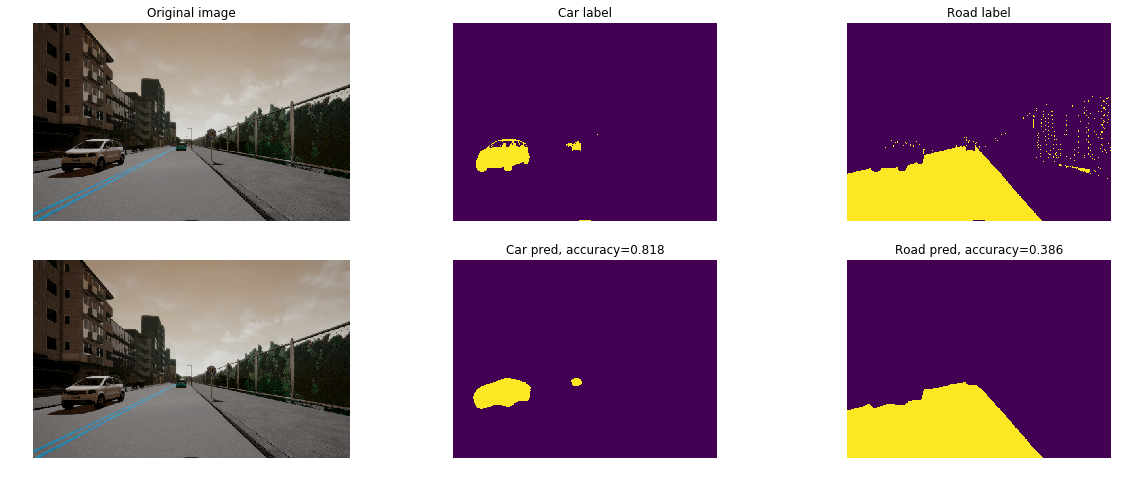

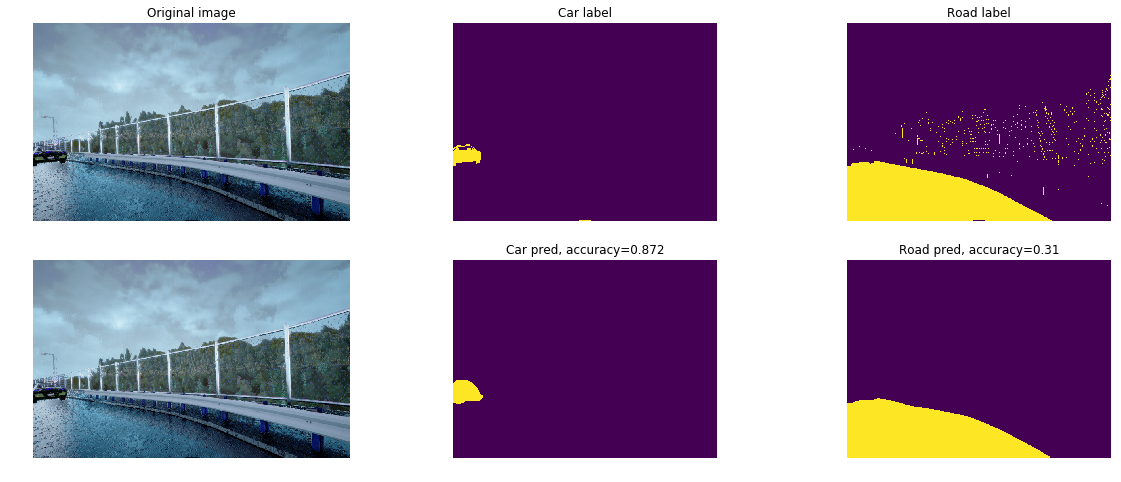

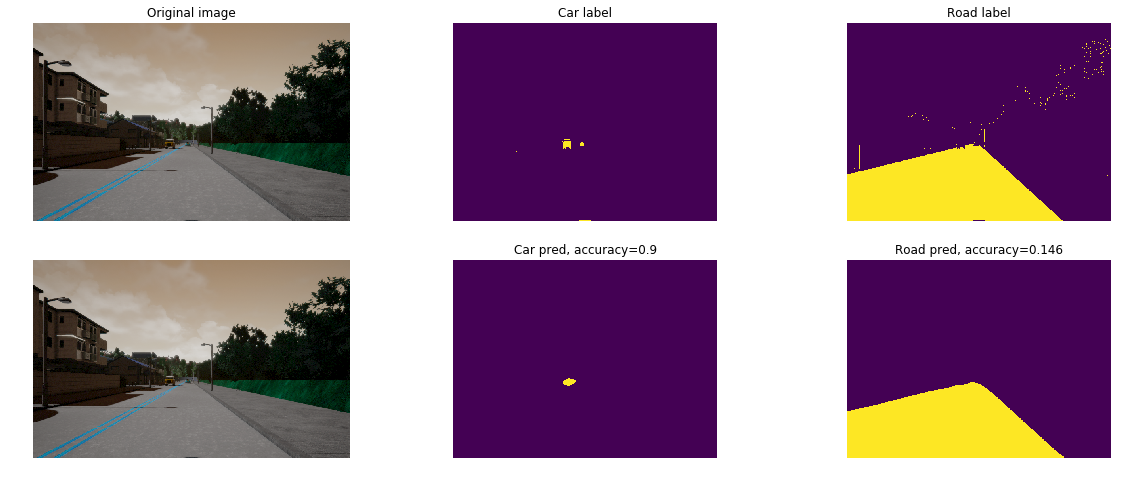

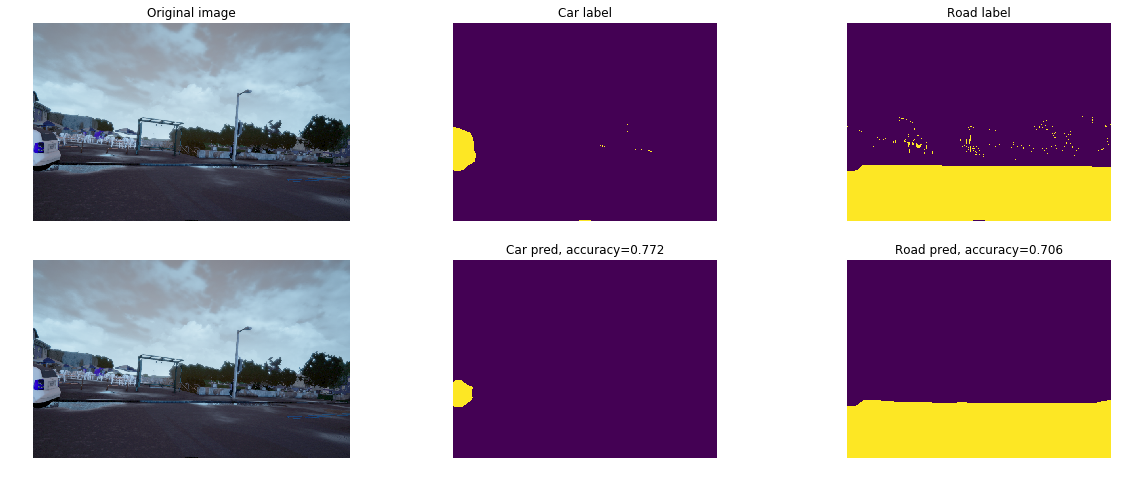

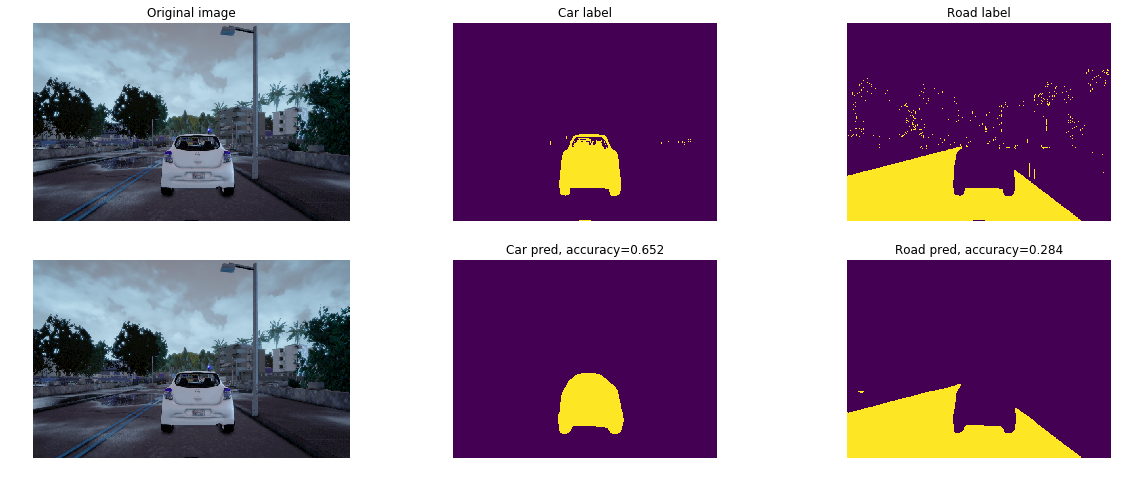

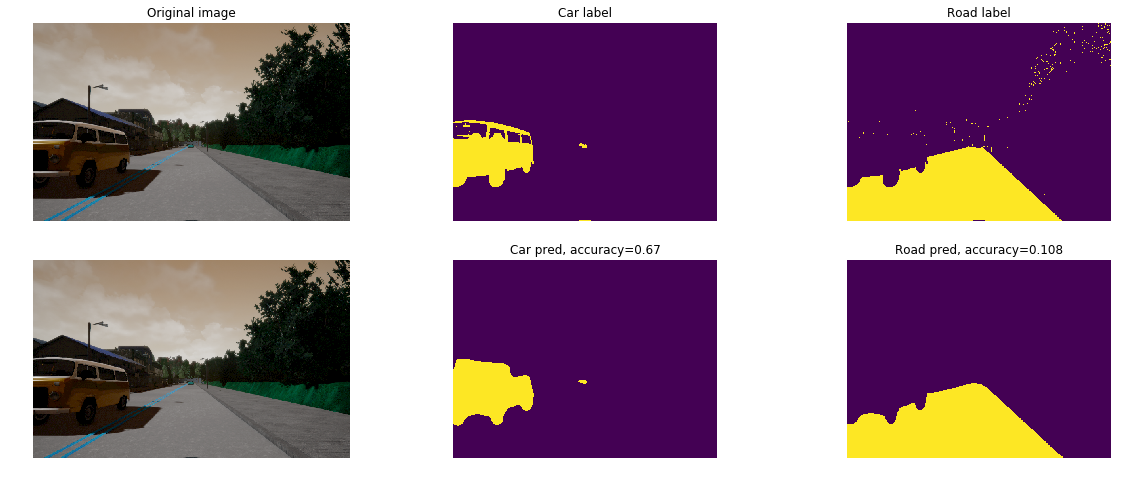

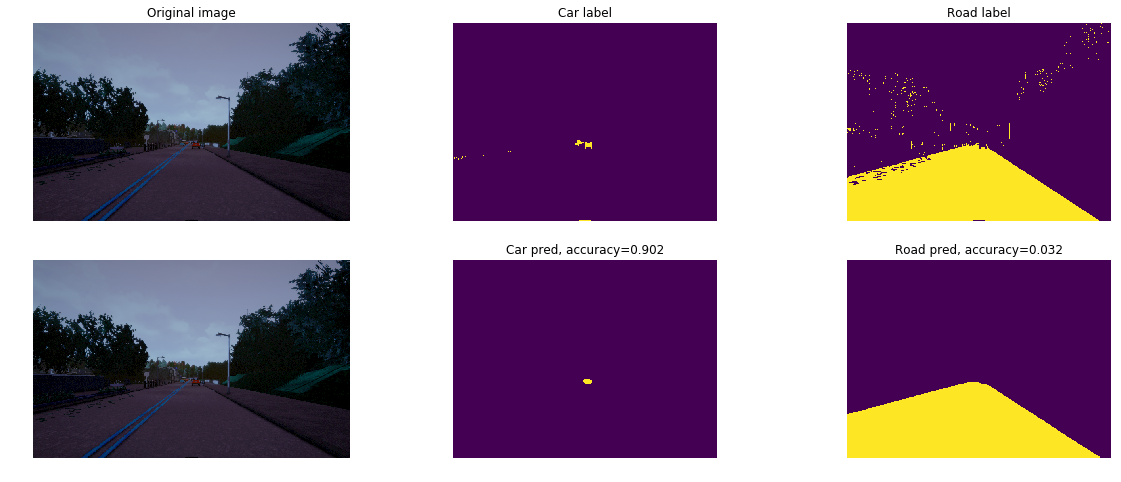

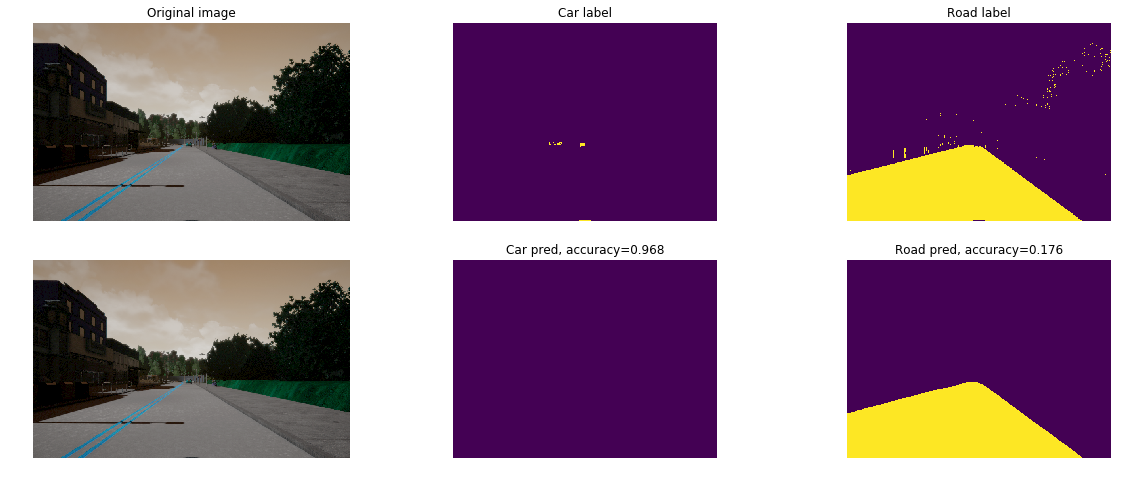

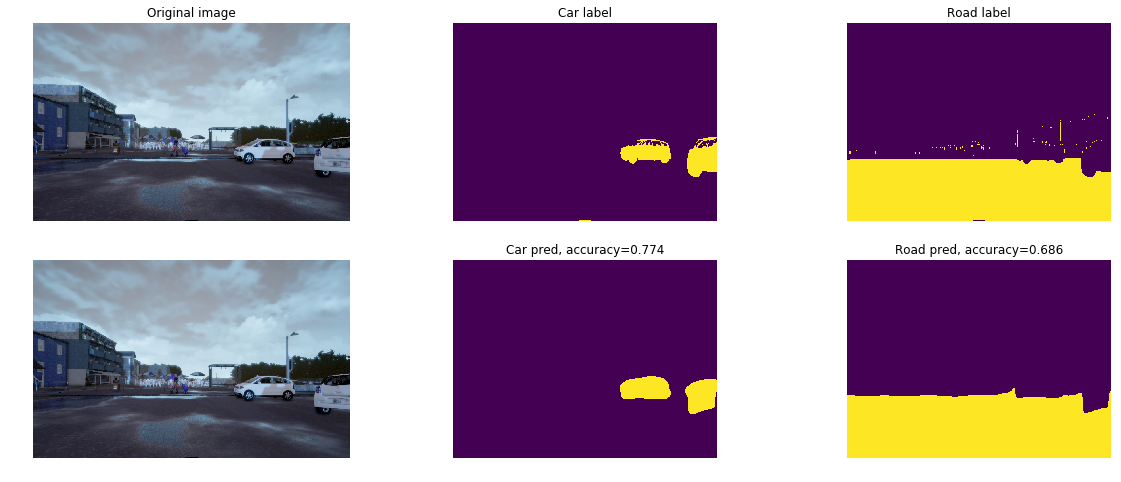

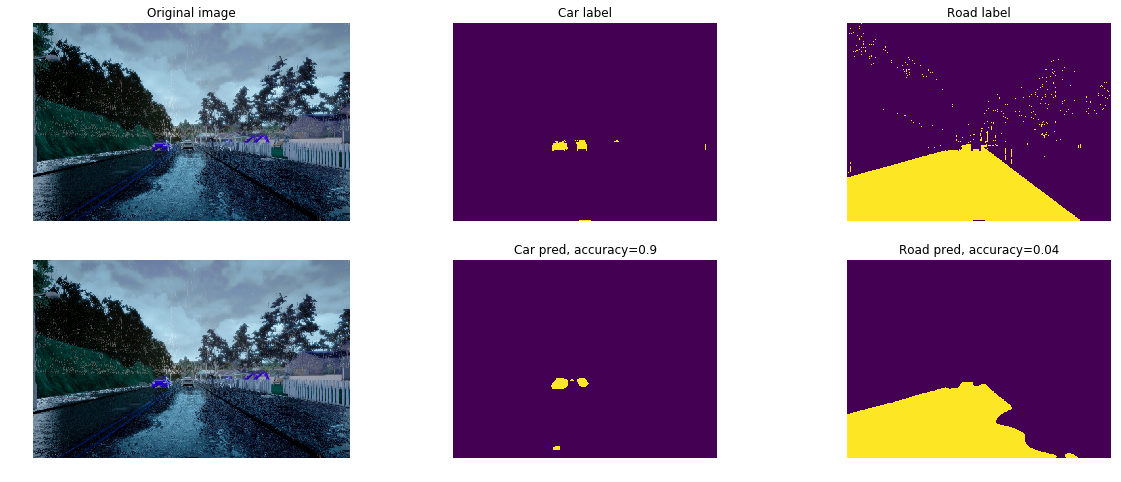

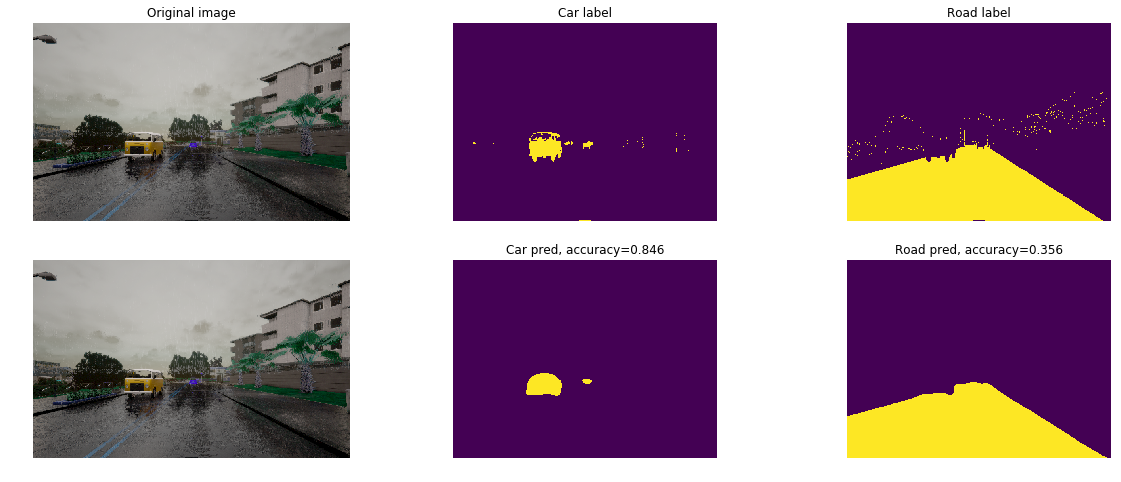

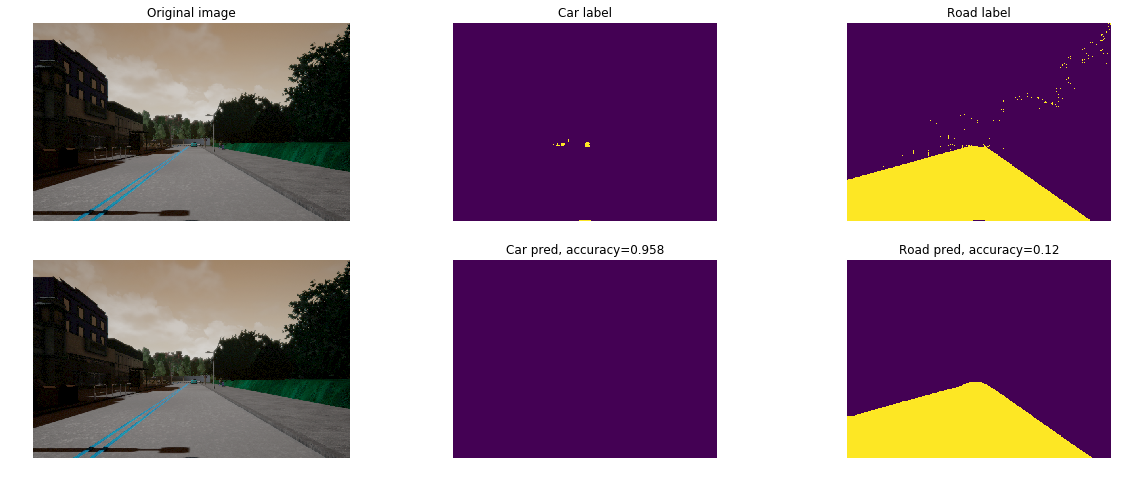

In [51]:
for i in range(len(test_samples)):
    test_img  = cv2.imread(test_samples.iloc[i]['image'])[:500,:,:]
    test_lbl  = cv2.imread(test_samples.iloc[i]['label'])[:,:,2]
    test_lbl = test_lbl[:500,:]
    test_lbl = cv2.resize(test_lbl, (666,500), interpolation = cv2.INTER_LINEAR)
    car_pred, road_pred = get_predictions(loaded_model, test_img)
    plot_results(test_img, test_lbl, car_pred, road_pred)

51~ ms. Since my GPU is roughly equal to Tesla K80, this must run at 20~ FPS.